# My attempt to implement the algorithm I was trying to explain yesterday 1/22

In [114]:
import numpy as np
import networkx as nx

Takes any graph with zero-indexed integer node attributes and computes every Betti number $H_k$ for $0 \le k \le n$, where $n$ is the size of the largest clique in the graph.

In [ ]:
def rank_mod2(matrix):
    """
    Computes the rank of a binary matrix over the field Z_2.
    Uses Gaussian elimination with boolean arithmetic.
    """
    # Work with a copy to avoid destroying the input
    matrix_copy = matrix.copy().astype(int)
    rows, cols = matrix_copy.shape
    rank = 0
    pivot_row = 0
    
    for col in range(cols):
        if pivot_row >= rows:
            break
            
        # Find a row with a 1 in the current column (pivot)
        # We search from pivot_row downwards
        pivot_candidates = np.where(matrix_copy[pivot_row:, col] == 1)[0]
        
        if len(pivot_candidates) > 0: # we've found a pivot
            rank += 1
            pivot_index = pivot_candidates[0] + pivot_row
            
            # Swap current row with pivot row if necessary
            if pivot_index != pivot_row:
                matrix_copy[[pivot_row, pivot_index]] = matrix_copy[[pivot_index, pivot_row]]
            
            # XOR elimination: Zero out all other 1s in this column
            # We look at all rows; for rows below, we eliminate.
            # Optimization: boolean XOR is equivalent to (row + pivot) % 2
            
            # Find rows below that have a 1 in this column
            rows_to_xor = np.where(matrix_copy[:, col] == 1)[0]
            # Exclude the pivot row itself
            rows_to_xor = rows_to_xor[rows_to_xor != pivot_row]
            
            # Perform row operations (M[i] = M[i] XOR M[pivot])
            if len(rows_to_xor) > 0:
                matrix_copy[rows_to_xor, :] ^= matrix_copy[pivot_row, :]
                
            pivot_row += 1
            
    return rank

In [ ]:
def betti_numbers(G:nx.Graph):
    """
    Given a colored graph, compute all of its non-trivial Betti numbers.
    returns a vector giving the dimensions k of the homology groups, 
    corresponding to their respective Betti numbers in the second vector.
    Ensure that the node labels of G are zero-indexed integers.
    """

    # first, find all cliques in the graph, sorted in descending order by size
    cliques = [clique for clique in nx.enumerate_all_cliques(G)][::-1]

    # we need to keep track of which positions in our matrices our cliques correspond to; we can arbitrarily define these so long as they remain consistent
    # define one dictionary for each size clique in our graph
    max_clique_size = max(map(len, cliques))
    position = [dict() for _ in range(max_clique_size)]

    k = max_clique_size # start with the max sized cliques
    i = 0 # index the cliques of size k
    j = 0 # index the positions

    for clique in cliques:
        if len(clique) < k:
            k = len(clique) # move to next size k
            j += 1 # move to next position in list of dictionaries
            i = 0 # reset k-clique index for new k
        
        curr_dict = position[j]
        curr_dict[tuple(clique)] = i # set the current clique to have value i in the appropriate dictionary
        i += 1


    
    # we can initialize our boundary matrices with zeros
    Matrix = [np.zeros((len(position[i + 1].keys()), len(position[i].keys()))) for i in range(max_clique_size - 1)]
    
    """
    Now, we need to loop through the cliques again and fill in the matrices.
    """

    k = max_clique_size
    j = 0
    for j in range(len(position) - 1):
        for clique, pos in position[j].items(): # iterate through each position, and each clique within each position
            for v in clique: # remove each vertex once exactly to get each face
                face = list(clique)
                face.remove(v)

                # for the jth matrix, find the row corresponding to the (j+1)th face, position corresponding to the clique's determined position
                Matrix[j][position[j + 1][tuple(face)], pos] = 1
        
    """
    Now, we compute the ranks, nullities, and consequently Betti numbers of these matrices.
    """

    # we go through and compute the ranks and nullities mod 2
    ranks = []
    nullities = []
    for M in Matrix:
        rank = rank_mod2(M)
        nullity = M.shape[1] - rank # rank nullity theorem

        ranks.append(rank)
        nullities.append(nullity)
    
    # now we start computing our betti numbers
    bettis = []
    
    # Somehow my code doesn't work for the very last map but that's okay we can compute it easily
    num_vertices = Matrix[-1].shape[0] # the number of vertices in the graph
    rank_d1 = ranks[-1] # the rank of one dimensional boundaries i.e. the dimension of the space spanned by edges
    bettis.append(num_vertices - rank_d1)
    
    # Reverse the lists to list the betti numbers in ascending order by dimension
    rev_nullities = nullities[::-1]
    rev_ranks = ranks[::-1]
    
    for k in range(len(rev_nullities) - 1):
        # compute the betti numbers
        val = rev_nullities[k] - rev_ranks[k+1]
        bettis.append(val)

    # for the last clique of highest dimension the rank of a higher dimensional boundary map is vacuously zero so the quotient group is equal to the kernel of this last boundary map
    bettis.append(rev_nullities[-1]) 

    # Return dimensions and values
    dims = np.arange(len(bettis))
    return dims, np.array(bettis)

In [99]:
G = nx.complete_graph(4)

betti_numbers(G)

[[0, 1, 2, 3], [1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2], [2, 3], [1, 3], [1, 2], [0, 3], [0, 2], [0, 1], [3], [2], [1], [0]]


(array([0, 1, 2, 3]), array([1, 0, 0, 0]))

Petersen's graph (should have 1 connected component, 6 cycles, no 3-cliques or greater.)

[[7, 9], [6, 9], [6, 8], [5, 8], [5, 7], [4, 9], [3, 8], [3, 4], [2, 7], [2, 3], [1, 6], [1, 2], [0, 5], [0, 4], [0, 1], [9], [8], [7], [6], [5], [4], [3], [2], [1], [0]]
[[1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


(array([0, 1]), array([1, 6]))

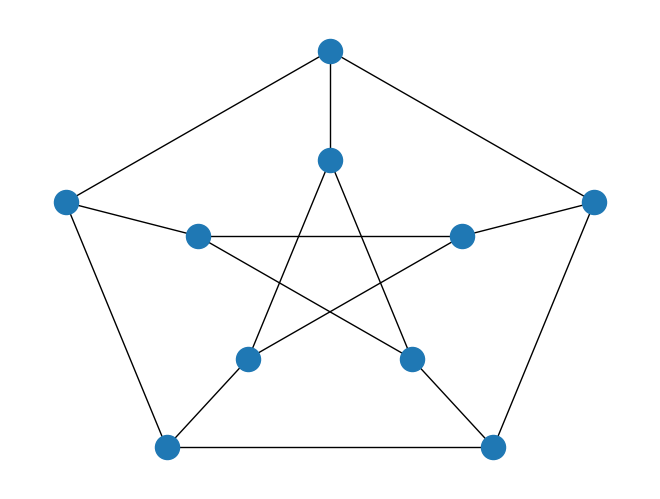

In [94]:
import math
def get_petersen_layout():
    layout = {}
    
    # We want vertex 0 at the top (90 degrees or pi/2)
    # 5 points, so each step is 2*pi / 5
    angle_step = 2 * math.pi / 5
    start_angle = math.pi / 2
    
    # Outer Pentagon (Radius 2)
    for i in range(5):
        angle = start_angle + (i * angle_step)
        layout[i] = (2 * math.cos(angle), 2 * math.sin(angle))
        
    # Inner Star (Radius 1)
    for i in range(5):
        angle = start_angle + (i * angle_step)
        # We index the inner vertices as 5-9
        layout[i + 5] = (1 * math.cos(angle), 1 * math.sin(angle))
        
    return layout

H = nx.petersen_graph()
nx.draw(H, pos = get_petersen_layout())
betti_numbers(H)

Disconnected components.

[[4, 5, 6], [1, 2, 3], [5, 6], [4, 6], [4, 5], [2, 3], [1, 3], [1, 2], [6], [5], [4], [3], [2], [1]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[[1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]


(array([0, 1, 2]), array([2, 0, 0]))

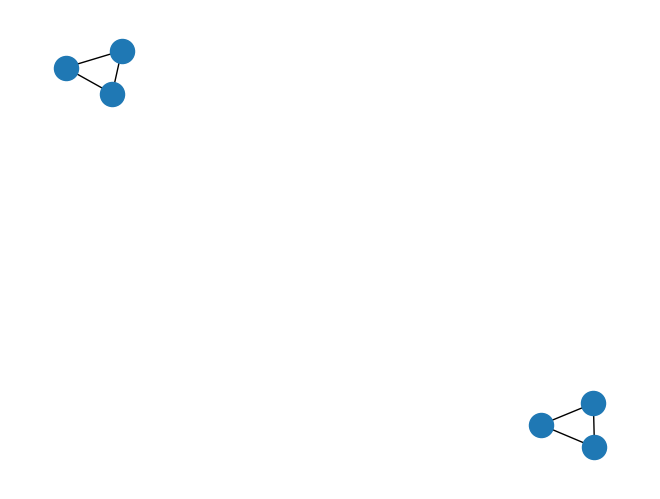

In [95]:
K = nx.Graph([
    (1, 2),
    (2, 3),
    (1, 3),
    (4, 5),
    (5, 6),
    (6, 4)
])
nx.draw(K)

betti_numbers(K)

Super large dense random graph. (DON'T RUN THIS CELL BELOW AGAIN!!!!)

In [109]:
J = nx.gnp_random_graph(100, .4)
betti_numbers(J)

(array([0, 1, 2, 3, 4, 5, 6]), array([  1,   0,  21, 942,   0,   0,   0]))

Now we adapt the mechanism to look for cliques so that it only considers cliques of the same color.

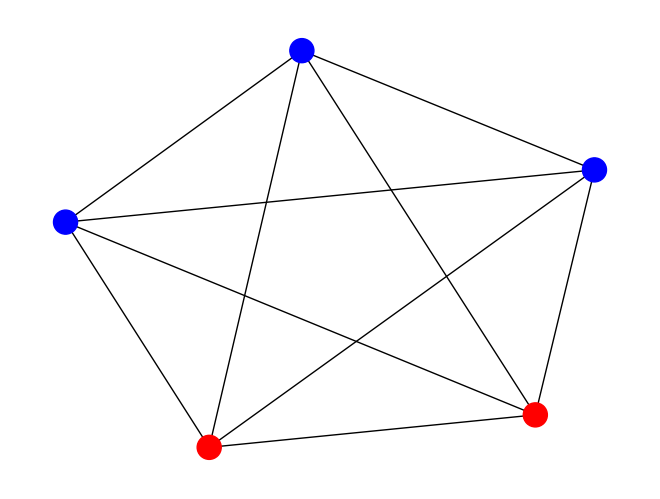

In [127]:
def filter_colored_subgraphs(G):
    
    colors = set(nx.get_node_attributes(G, "color").values())
    for color in colors:
        def filter_func(node, c = color):
            return G.nodes[node].get("color") == c
        
        yield nx.subgraph_view(G, filter_node=filter_func)


G = nx.complete_graph(5)
rand_colors = list(np.random.choice(['red', 'blue'], size = len(G.nodes), replace = True))
mapping = dict(zip(list(G.nodes), rand_colors))
nx.set_node_attributes(G, mapping, "color")
nx.draw(G, node_color = rand_colors)

In [ ]:
def betti_numbers(G:nx.Graph):
    """
    Given a colored graph, compute all of its non-trivial Betti numbers.
    returns a vector giving the dimensions k of the homology groups, 
    corresponding to their respective Betti numbers in the second vector.
    Ensure that the node labels of G are zero-indexed integers.
    """
    def filter_colored_subgraphs(G):
        """
        Generates colored subgraph views for computing colored cliques based on node attribute color.
        """
        colors = set(nx.get_node_attributes(G, "color").values())
        for color in colors:
            def filter_func(node, c = color):
                return G.nodes[node].get("color") == c
        
            yield nx.subgraph_view(G, filter_node=filter_func)

    # first, find all cliques in the graph, sorted in descending order by size
    # this is the change from the previous version to find the colored cliques only
    cliques = sorted([clique for H in filter_colored_subgraphs(G) for clique in nx.enumerate_all_cliques(H)], key=len, reverse=True)
    # we need to keep track of which positions in our matrices our cliques correspond to; we can arbitrarily define these so long as they remain consistent
    # define one dictionary for each size clique in our graph
    max_clique_size = max(map(len, cliques))
    position = [dict() for _ in range(max_clique_size)]

    k = max_clique_size # start with the max sized cliques
    i = 0 # index the cliques of size k
    j = 0 # index the positions

    for clique in cliques:
        if len(clique) < k:
            k = len(clique) # move to next size k
            j += 1 # move to next position in list of dictionaries
            i = 0 # reset k-clique index for new k
        
        curr_dict = position[j]
        curr_dict[tuple(clique)] = i # set the current clique to have value i in the appropriate dictionary
        i += 1


    
    # we can initialize our boundary matrices with zeros
    Matrix = [np.zeros((len(position[i + 1].keys()), len(position[i].keys()))) for i in range(max_clique_size - 1)]
    
    """
    Now, we need to loop through the cliques again and fill in the matrices.
    """

    k = max_clique_size
    j = 0
    for j in range(len(position) - 1):
        for clique, pos in position[j].items(): # iterate through each position, and each clique within each position
            for v in clique: # remove each vertex once exactly to get each face
                face = list(clique)
                face.remove(v)

                # for the jth matrix, find the row corresponding to the (j+1)th face, position corresponding to the clique's determined position
                Matrix[j][position[j + 1][tuple(face)], pos] = 1
        
    """
    Now, we compute the ranks, nullities, and consequently Betti numbers of these matrices.
    """

    # we go through and compute the ranks and nullities mod 2
    ranks = []
    nullities = []
    for M in Matrix:
        rank = rank_mod2(M)
        nullity = M.shape[1] - rank # rank nullity theorem

        ranks.append(rank)
        nullities.append(nullity)
    
    # now we start computing our betti numbers
    bettis = []
    
    # Somehow my code doesn't work for the very last map but that's okay we can compute it easily
    num_vertices = Matrix[-1].shape[0] # the number of vertices in the graph
    rank_d1 = ranks[-1] # the rank of one dimensional boundaries i.e. the dimension of the space spanned by edges
    bettis.append(num_vertices - rank_d1)
    
    # Reverse the lists to list the betti numbers in ascending order by dimension
    rev_nullities = nullities[::-1]
    rev_ranks = ranks[::-1]
    
    for k in range(len(rev_nullities) - 1):
        # compute the betti numbers
        val = rev_nullities[k] - rev_ranks[k+1]
        bettis.append(val)

    # for the last clique of highest dimension the rank of a higher dimensional boundary map is trivial so the quotient group is equal to the kernel of this last boundary map
    bettis.append(rev_nullities[-1]) 

    # Return dimensions and values
    dims = np.arange(len(bettis))
    return dims, np.array(bettis)

In [129]:
betti_numbers(G)

(array([0, 1, 2]), array([2, 0, 0]))

[1, 2, 3, 4]


(array([0, 1]), array([2, 0]))

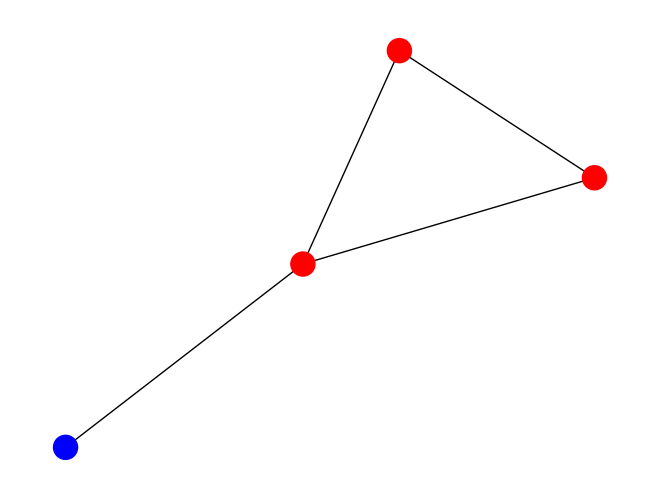

In [135]:
L = nx.Graph([
    (1, 2),
    (2, 3),
    (3, 1),
    (1, 4)
])

colors = dict(zip(list(G.nodes), ['red', 'red', 'red', 'blue']))
nx.set_node_attributes(L, colors, 'color')
print(list(L.nodes))

nx.draw(L, node_color = ['red', 'red', 'red', 'blue'])
betti_numbers(L)